In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, mapping, Point
import numpy as np
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True, nb_workers=4)
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
def distance(x1, x2, y1, y2):
    R = 6373.0
    
    lat1 = np.radians(x1)
    lat2 = np.radians(x2)
    lon1 = np.radians(y1) 
    lon2 = np.radians(y2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

In [5]:
df = pd.read_csv('../export/ads_moscow_31_05_2022.csv', names=[
                'id',
                'date',
                'region',
                'city',
                'address',
                'price',
                'sqr_total',
                'latitude',
                'longitude',
                'build_year',
                'url',
                'description',
                'photos'
            ])

In [6]:
df = df.drop_duplicates('address')
df = df[df['sqr_total'] < 1200]
# df = df[df['price'] < df['price'].quantile(0.99)]

<AxesSubplot:xlabel='sqr_total', ylabel='price'>

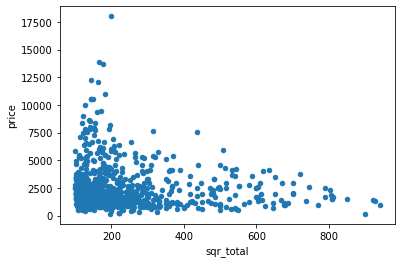

In [8]:
df.plot.scatter(x='sqr_total', y='price')

<AxesSubplot:xlabel='sqr_total', ylabel='price'>

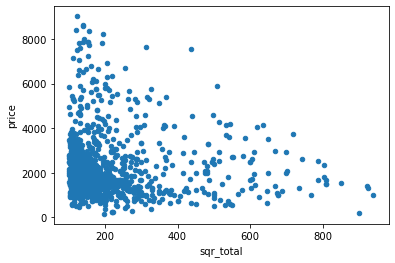

In [9]:
df[df['price'] < df['price'].quantile(0.99)].plot.scatter(x='sqr_total', y='price')

In [11]:
df[df['price'] < df['price'].quantile(0.99)].to_csv('../export/ads_moscow_15_06_2022.csv', index=False)

In [70]:
df_93_percentile = df.groupby('region', as_index=False)['price'].quantile(0.93).rename({'price': 'percentile_93'}, axis=1)
df_95_percentile = df.groupby('region', as_index=False)['price'].quantile(0.95).rename({'price': 'percentile_95'}, axis=1)
df_99_percentile = df.groupby('region', as_index=False)['price'].quantile(0.99).rename({'price': 'percentile_99'}, axis=1)

In [71]:
df_temp = df.merge(df_99_percentile, on='region', how='left')

In [72]:
df_temp = df_temp[df_temp['price'] < df_temp['percentile_99']]

In [73]:
df_temp = df_temp[df_temp['price'] < 10000]

<AxesSubplot:xlabel='sqr_total', ylabel='price'>

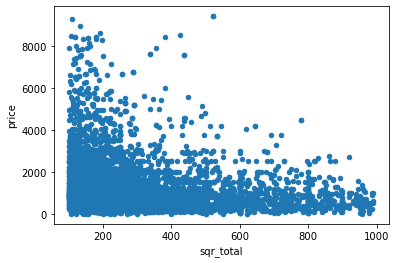

In [74]:
df_temp.plot.scatter(x='sqr_total', y='price')

<AxesSubplot:>

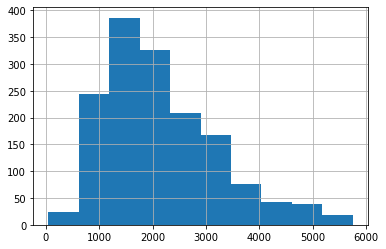

In [43]:
df_temp[df_temp['city'] == 'Москва']['price'].hist()

In [76]:
df_temp.to_csv('../../cian_ads_russia.csv', index=False)

In [53]:
df_moscow = df_temp[df_temp['city'] == 'Москва']

In [55]:
import folium

m = folium.Map(location=[55.755811, 37.617617], zoom_start=11)

for i, point in tqdm(df_moscow.iterrows(), total=len(df_moscow)):
#     print(point)
#     print(point['price'])
    popup = folium.Popup('{}'.format(point['price']))
    folium.Marker(location=[point['latitude'], point['longitude']], popup=popup).add_to(m)

In [56]:
m

In [39]:
df_temp.to_csv('../../../../Downloads/real_estate_dataset.csv', index=False)

In [110]:
df_vsp = pd.read_excel('../../../DATA/Отчёт по площадям 28_02_2022.xlsx', header=2)

In [112]:
df_vsp = df_vsp[
    (df_vsp['City'] == 'г.Москва')
]

<AxesSubplot:>

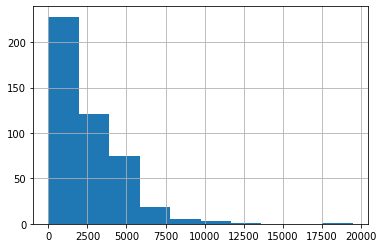

In [113]:
df_vsp['rent_rate_avg'].hist()

<AxesSubplot:xlabel='sqr_total', ylabel='rent_rate_avg'>

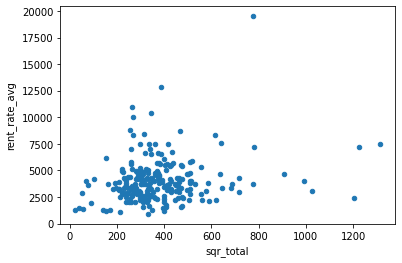

In [114]:
df_vsp[df_vsp['rent_rate_avg'] != 0].plot.scatter(x='sqr_total', y='rent_rate_avg')

<AxesSubplot:>

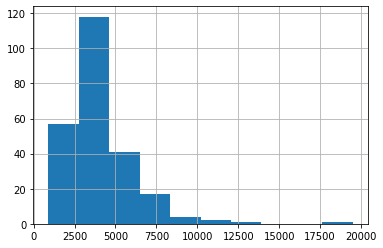

In [115]:
df_vsp[df_vsp['rent_rate_avg'] != 0]['rent_rate_avg'].hist()

In [79]:
df['date'] = pd.to_datetime(df['date'])

In [94]:
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: x.year)

<AxesSubplot:xlabel='month'>

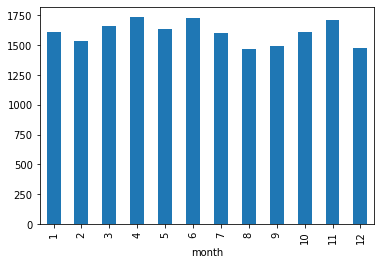

In [92]:
df.groupby('month')['price'].mean().plot.bar()

<AxesSubplot:xlabel='month'>

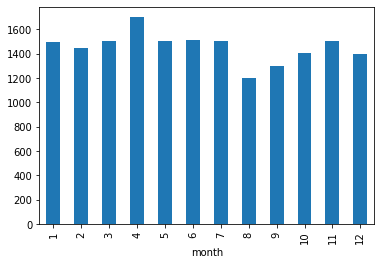

In [93]:
df.groupby('month')['price'].median().plot.bar()

<AxesSubplot:xlabel='year'>

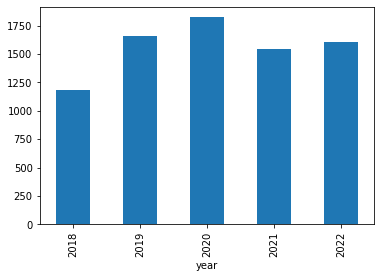

In [95]:
df.groupby('year')['price'].mean().plot.bar()

<AxesSubplot:xlabel='year'>

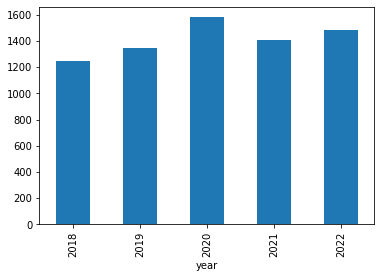

In [96]:
df.groupby('year')['price'].median().plot.bar()

In [102]:
df = df[['latitude', 'longitude', 'sqr_total', 'price']]

In [103]:
df.to_csv('../../../../Downloads/train_sp')

,latitude,longitude,sqr_total,price
0,59.968056,30.301809,271.40,1400
1,59.902131,30.324905,252.00,1600
2,59.929060,30.321680,162.00,2777
3,59.967529,30.288119,120.00,1500
4,59.967529,30.288119,430.00,1500
...,...,...,...,...
1383,59.874038,30.257954,300.00,2241
1384,59.874038,30.257954,672.40,1000
1385,59.844768,30.280124,712.00,950
1386,60.058219,30.349815,453.69,1500


In [127]:
df_cities = gpd.read_file('../../../DATA/POLYGONS/Settlements/')

In [137]:
df_cities = df_cities[df_cities['OBJECTID'] == 24918]

In [143]:
df = df[['price', 'sqr_total', 'latitude', 'longitude']]
df['geometry'] = df.progress_apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
df = gpd.GeoDataFrame(df)

  0%|          | 0/1620 [00:00<?, ?it/s]

/Users/a19329895/.local/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
<ipython-input-143-a696c06f8ce9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['geometry'] = df.progress_apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)


In [148]:
# df = df.sjoin(df_cities[['geometry']], how='inner')
df = df.drop(['geometry', 'index_right'], axis=1)

In [149]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location = [55.755819, 37.617644], tiles = "CartoDB Positron", zoom_start=12)

HeatMap(list(zip(
    df.latitude,
    df.longitude,
    df.price)),
    min_opacity=0.6,
    radius=17, blur=25, 
    max_zoom=1,
    show=True
).add_to(m)

m

In [125]:
m = folium.Map(location = [55.755819, 37.617644], tiles = "CartoDB Positron", zoom_start=12)

HeatMap(list(zip(
    df_vsp.geo_lat,
    df_vsp.geo_lng,
    df_vsp.rent_rate_avg)),
    min_opacity=0.6,
    radius=17, blur=25, 
    max_zoom=1,
    show=True
).add_to(m)

m

In [151]:
df.to_csv('../../../../Downloads/train_msk.csv', index=False)

In [6]:
CITIES = [
    ('Москва', 1),
    ('Санкт-Петербург', 2),
    ('Республика Адыгея', 4553),
    ('Республика Алтай', 4554),
    ('Алтайский край', 4555),
    ('Амурская область', 4556),
    ('Архангельская область', 4557),
    ('Астраханская область', 4558),
    ('Республика Башкортостан', 4560),
    ('Белгородская область', 4561),
    ('Брянская область', 4562),
    ('Республика Бурятия', 4563),
    ('Владимирская область', 4564),
    ('Волгоградская область', 4565),
    ('Вологодская область', 4566),
    ('Воронежская область', 4567),
    ('Республика Дагестан', 4568),
    ('Еврейская автономная область', 4569),
    ('Ивановская область', 4570),
    ('Республика Ингушетия', 4571),
    ('Иркутская область', 4572),
    ('Кабардино-Балкарская Республика', 4573),
    ('Калининградская область', 4574),
    ('Республика Калмыкия', 4575),
    ('Калужская область', 4576),
    ('Камчатский край', 4577),
    ('Карачаево-Черкесская Республика', 4578),
    ('Республика Карелия', 4579),
    ('Кемеровская область', 4580),
    ('Кировская область', 4581),
    ('Республика Коми', 4582),
    ('Костромская область', 4583),
    ('Краснодарский край', 4584),
    ('Красноярский край', 4585),
    ('Курганская область', 4586),
    ('Курская область', 4587),
    ('Ленинградская область', 4588),
    ('Липецкая область', 4589),
    ('Магаданская область', 4590),
    ('Республика Марий Эл', 4591),
    ('Республика Мордовия', 4592),
    ('Московская область', 4593),
    ('Мурманская область', 4594),
    ('Ненецкий автономный округ', 4595),
    ('Нижегородская область', 4596),
    ('Новгородская область', 4597),
    ('Новосибирская область', 4598),
    ('Омская область', 4599),
    ('Оренбургская область', 4600),
    ('Орловская область', 4601),
    ('Пензенская область', 4602),
    ('Пермский край', 4603),
    ('Приморский край', 4604),
    ('Псковская область', 4605),
    ('Ростовская область', 4606),
    ('Рязанская область', 4607),
    ('Самарская область', 4608),
    ('Саратовская область', 4609),
    ('Республика Саха (Якутия)', 4610),
    ('Сахалинская область', 4611),
    ('Свердловская область', 4612),
    ('Республика Северная Осетия - Алания', 4613),
    ('Смоленская область', 4614),
    ('Ставропольский край', 4615),
    ('Тамбовская область', 4617),
    ('Республика Татарстан', 4618),
    ('Тверская область', 4619),
    ('Томская область', 4620),
    ('Тульская область', 4621),
    ('Республика Тыва', 4622),
    ('Тюменская область', 4623),
    ('Удмуртская Республика', 4624),
    ('Ульяновская область', 4625),
    ('Хабаровский край', 4627),
    ('Республика Хакасия', 4628),
    ('Ханты-Мансийский автономный округ', 4629),
    ('Челябинская область', 4630),
    ('Чеченская Республика', 4631),
    ('Чувашская Республика', 4633),
    ('Чукотский автономный округ', 4634),
    ('Ямало-Ненецкий автономный округ', 4635),
    ('Ярославская область', 4636),
    ('Республика Крым', 181462),
    ('Севастополь', 184723),
    ('Забайкальский край', 187450)
]

In [8]:
regions = [x[0] for x in CITIES]

In [10]:
list(regions)

['Москва',
 'Санкт-Петербург',
 'Республика Адыгея',
 'Республика Алтай',
 'Алтайский край',
 'Амурская область',
 'Архангельская область',
 'Астраханская область',
 'Республика Башкортостан',
 'Белгородская область',
 'Брянская область',
 'Республика Бурятия',
 'Владимирская область',
 'Волгоградская область',
 'Вологодская область',
 'Воронежская область',
 'Республика Дагестан',
 'Еврейская автономная область',
 'Ивановская область',
 'Республика Ингушетия',
 'Иркутская область',
 'Кабардино-Балкарская Республика',
 'Калининградская область',
 'Республика Калмыкия',
 'Калужская область',
 'Камчатский край',
 'Карачаево-Черкесская Республика',
 'Республика Карелия',
 'Кемеровская область',
 'Кировская область',
 'Республика Коми',
 'Костромская область',
 'Краснодарский край',
 'Красноярский край',
 'Курганская область',
 'Курская область',
 'Ленинградская область',
 'Липецкая область',
 'Магаданская область',
 'Республика Марий Эл',
 'Республика Мордовия',
 'Московская область',
 'М